<a href="https://colab.research.google.com/github/Ciph3r007/Normalizing-Flow-and-VAE/blob/main/Normalizing_Flow_and_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normalizing Flow and VAE

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/colab_data/nflow_vae

For the capstone project, you will create your own image dataset from contour plots of a transformed distribution using a random normalising flow network. You will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

# The Normalising Flow
In this project, a random normalising flow network is used to create synthetic image dataset from contour plots of a transformed distribution. It is done by transforming 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

In [ ]:
# Distributions

base_dist = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[.3, .3])
theta_dist = tfd.Uniform(0., 2*np.pi)
a_dist = tfd.Normal(3., 1.)

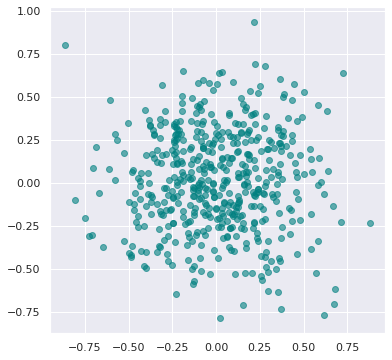

In [ ]:
# Plotting 500 z samples

z = base_dist.sample(500)

plt.figure(figsize = (6, 6))
plt.scatter(z[:, 0], z[:, 1], c='teal', alpha=.6)
plt.show()

In [ ]:
# 3rd bijector of the flow network

class Polynomial(tfb.Bijector):
  def __init__(self, a, validate_args=False, name='Polynomial', **kwargs):
    super(Polynomial, self).__init__(name=name,
                                 validate_args=validate_args,
                                 forward_min_event_ndims=1,
                                 is_constant_jacobian=True,
                                 **kwargs)
    self.a = tf.cast(a, dtype=tf.float32)
    
  def _forward(self, z):
    z = tf.cast(z, dtype=tf.float32)
    x = tf.concat([z[..., :1], z[..., 1:] + self.a * tf.square(z[..., :1])], 
                   axis=-1)
    return x

  def _inverse(self, x):
    x = tf.cast(x, dtype=tf.float32)
    z = tf.concat([x[..., :1], x[..., 1:] - self.a * tf.square(x[..., :1])], 
                   axis=-1)
    return z
  
  def _forward_log_det_jacobian(self, z):
    return tf.constant(0.)

In [ ]:
# 4th bijector of the flow network

class Rotate(tfb.Bijector):
  def __init__(self, theta, validate_args=False, name='Rotation', **kwargs):
    super(Rotate, self).__init__(name=name,
                                 validate_args=validate_args,
                                 forward_min_event_ndims=1,
                                 is_constant_jacobian=True,
                                 **kwargs)
    self.rot_matrix = tf.convert_to_tensor([[tf.cos(theta), -tf.sin(theta)],
                                            [tf.sin(theta), tf.cos(theta)]],
                                            dtype=tf.float32)
  
  def _forward(self, z):
    z = tf.cast(z, dtype=tf.float32)
    x = tf.linalg.matvec(self.rot_matrix, z)
    return x

  def _inverse(self, x):
    x = tf.cast(x, dtype=tf.float32)
    z = tf.linalg.matvec(self.rot_matrix, x, transpose_a=True)
    return z
  
  def _forward_log_det_jacobian(self, z):
    return tf.constant(0.)

In [ ]:
def flow(a, theta, base_dist):
  f1 = tfb.Shift([0., -2.])
  f2 = tfb.Scale([1., .5])
  f3 = Polynomial(a)
  f4 = Rotate(theta)
  f5 = tfb.Tanh()

  bijector = tfb.Chain([f5, f4, f3, f2, f1])
  dist = tfd.TransformedDistribution(base_dist, bijector)

  return dist

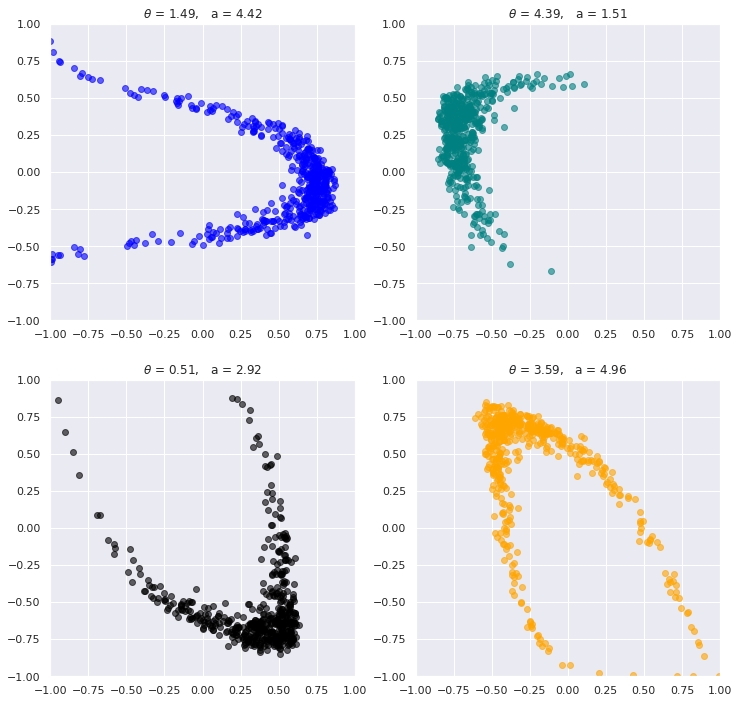

In [ ]:
# Visualizing the transformed distribution

colors = ['blue', 'teal', 'black', 'orange']

plt.figure(figsize=(12, 12))
for i in range(4):
  a = a_dist.sample()
  theta = theta_dist.sample()
  samples = flow(a, theta, base_dist).sample(500)

  plt.subplot(2, 2, i+1)
  plt.scatter(samples[:, 0], samples[:, 1], c=colors[i], alpha=0.6)
  plt.title(f'$\\theta$ = {theta:.2f},   a = {a:.2f}')
  plt.xlim([-1, 1])
  plt.ylim([-1, 1])

plt.show()

## 2. Creating the Synthetic Image Dataset

In [ ]:
# Function to compute transformed distribution densities for the contour plot

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

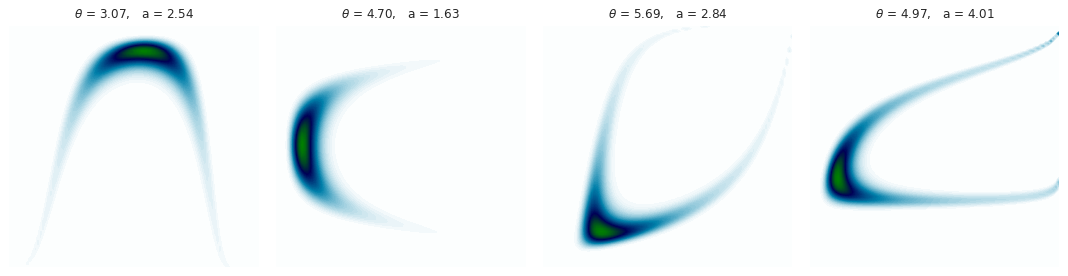

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(4):
  a = a_dist.sample()
  theta = theta_dist.sample()
  dist = flow(a, theta, base_dist)
  dist = tfd.BatchReshape(dist, [1])
  Z = get_densities(dist).squeeze()

  plt.subplot(1, 4, i+1)
  plt.contourf(X, Y, Z, cmap='ocean_r', levels=100)
  plt.title(f'$\\theta$ = {theta:.2f},   a = {a:.2f}')
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='ocean_r', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,)
        )
    return image_from_plot

In [ ]:
N = 1000
images = []

for i in tqdm_notebook(range(N)):
  a = a_dist.sample()
  theta = theta_dist.sample()
  dist = flow(a, theta, base_dist)
  dist = tfd.BatchReshape(dist, [1])
  Z = get_densities(dist).squeeze()

  img = get_image_array_from_density_values(Z)
  images.append(img)

images = np.array(images)

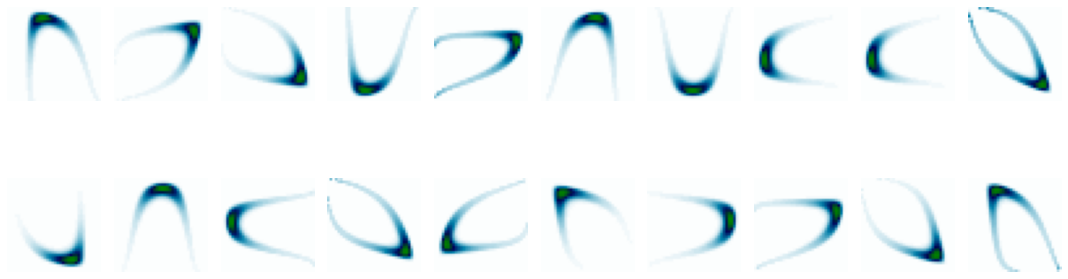

In [ ]:
# Some of the synthetic images

index = np.random.choice(N, 20)
plt.figure(figsize = (15, 6))

for i in range(20):
  plt.subplot(2, 10, i+1)
  plt.imshow(images[index[i]])
  plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Input Pipeline

In [ ]:
def split_data(data, val_fraction=0.1, test_fraction=0.1):
  data = data.astype(np.float32)
  N = data.shape[0]
  val_size = int(N * val_fraction)
  test_size = int(N * test_fraction)
  train_size = N - val_size - test_size

  train_idx = np.random.choice(N, train_size, replace=False)
  train_data = tf.data.Dataset.from_tensor_slices(data[train_idx])
  train_data = train_data.map(lambda x: x/255.)
  train_data = train_data.map(lambda x: (x, x))
  train_data = train_data.shuffle(train_size)
  train_data = train_data.batch(20, drop_remainder=True)

  val_idx = np.random.choice(N, val_size, replace=False)
  val_data = tf.data.Dataset.from_tensor_slices(data[val_idx])
  val_data = val_data.map(lambda x: x/255.)
  val_data = val_data.map(lambda x: (x, x))
  val_data = val_data.batch(20, drop_remainder=True)

  test_idx = np.random.choice(N, test_size, replace=False)
  test_data = tf.data.Dataset.from_tensor_slices(data[test_idx])
  test_data = test_data.map(lambda x: x/255.)
  test_data = test_data.map(lambda x: (x, x))
  test_data = test_data.batch(20, drop_remainder=True)

  return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = split_data(images)
train_data.element_spec

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))

## 4. Encoder and Decoder Networks for the VAE

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Conv2D, MaxPool2D, Conv2DTranspose,
                                     UpSampling2D, Flatten, BatchNormalization,
                                     Reshape)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

latent_dim = 2
image_shape = (36, 36, 3)

In [ ]:
def get_prior(latent_dim=latent_dim):
  prior = tfd.MultivariateNormalDiag(
      loc=tf.Variable(tf.zeros(latent_dim), dtype=tf.float32),
      scale_diag=tfp.util.TransformedVariable(
          initial_value=tf.ones(latent_dim, dtype=tf.float32),
          bijector=tfb.Softplus()
      )
  )

  return prior

In [ ]:
def get_kl_regularizer(prior):
  regularizer = tfpl.KLDivergenceRegularizer(
      prior,
      test_points_fn=lambda q: q.sample(5),
      test_points_reduce_axis=(0, 1)
  )

  return regularizer

In [ ]:
def get_encoder(input_shape, kl_regularizer, latent_dim=latent_dim):
  encoder = Sequential([
      Conv2D(32, 3, input_shape=input_shape, padding= 'SAME', activation='relu'),
      MaxPool2D(),
      BatchNormalization(),
      Conv2D(64, 3, padding='SAME', activation='relu'),
      MaxPool2D(),
      BatchNormalization(),
      Flatten(),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
      tfpl.MultivariateNormalTriL(
          event_size=latent_dim, 
          activity_regularizer=kl_regularizer
      )
  ])

  return encoder

In [ ]:
prior = get_prior()
kl_regularizer = get_kl_regularizer(prior)

tf.keras.backend.clear_session()
encoder = get_encoder(input_shape=image_shape, kl_regularizer=kl_regularizer)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0

In [ ]:
def get_decoder(event_shape, latent_dim=latent_dim):
  decoder = Sequential([
      Dense(32, input_shape=(latent_dim,), activation='relu'),
      Dense(64, activation='relu'),
      Dense(128, activation='relu'),
      Dense(9*9*64, activation='relu'),
      Reshape(target_shape=(9, 9, 64)),
      BatchNormalization(),
      UpSampling2D(),
      Conv2DTranspose(32, 3, padding='SAME', activation='relu'),
      BatchNormalization(),
      UpSampling2D(),
      Conv2DTranspose(3, 3, padding='SAME'),
      Flatten(),
      tfpl.IndependentBernoulli(event_shape)
  ])

  return decoder

In [ ]:
decoder = get_decoder(image_shape)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 5184)              668736    
_________________________________________________________________
reshape (Reshape)            (None, 9, 9, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 18, 18, 64)       

## 5. Training the VAE

In [ ]:
def get_vae(encoder, decoder):
  model = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
  model.compile(
      loss=lambda y_true, y_pred: -tf.reduce_mean(y_pred.log_prob(y_true)),
      optimizer='adam'
  )

  return model

In [ ]:
vae = get_vae(encoder, decoder)
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 36, 36, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 36, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256   

In [ ]:
checkpoint = ModelCheckpoint('checkpoints/checkpoint', 
                             save_weights_only=True, 
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
history = vae.fit(train_data,
                  validation_data=val_data,
                  epochs=100,
                  callbacks=[checkpoint, early_stopping])

Epoch 1/100
40/40 [==============================] - 8s 138ms/step - loss: 2387.7078 - val_loss: 2373.7009

Epoch 00001: val_loss improved from inf to 2373.70093, saving model to checkpoints/checkpoint
Epoch 2/100
40/40 [==============================] - 4s 108ms/step - loss: 1410.2662 - val_loss: 1475.0802

Epoch 00002: val_loss improved from 2373.70093 to 1475.08020, saving model to checkpoints/checkpoint
Epoch 3/100
40/40 [==============================] - 4s 110ms/step - loss: 723.8253 - val_loss: 1050.7374

Epoch 00003: val_loss improved from 1475.08020 to 1050.73743, saving model to checkpoints/checkpoint
Epoch 4/100
40/40 [==============================] - 4s 110ms/step - loss: 573.0157 - val_loss: 976.1705

Epoch 00004: val_loss improved from 1050.73743 to 976.17053, saving model to checkpoints/checkpoint
Epoch 5/100
40/40 [==============================] - 4s 110ms/step - loss: 554.7694 - val_loss: 923.2917

Epoch 00005: val_loss improved from 976.17053 to 923.29175, saving mo

In [ ]:
vae.evaluate(test_data)

5/5 [==============================] - 0s 36ms/step - loss: 448.0977


448.0977478027344

In [ ]:
df = pd.DataFrame(history.history)
df.tail()

,loss,val_loss
44,454.499268,459.510864
45,456.882660,458.707886
46,457.529724,462.431610
47,461.074341,461.816589
48,456.966980,460.015900


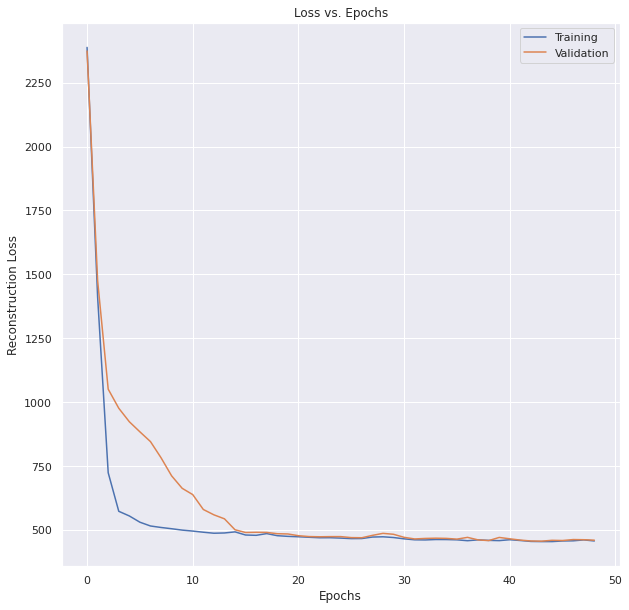

In [ ]:
plt.figure(figsize=(10, 10))

plt.plot(df['loss'], label='Training')
plt.plot(df['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.title('Loss vs. Epochs')
plt.legend()

## 6. Testing Image Reconstruction and New Image Generation

In [ ]:
z = encoder(images/255).mean()

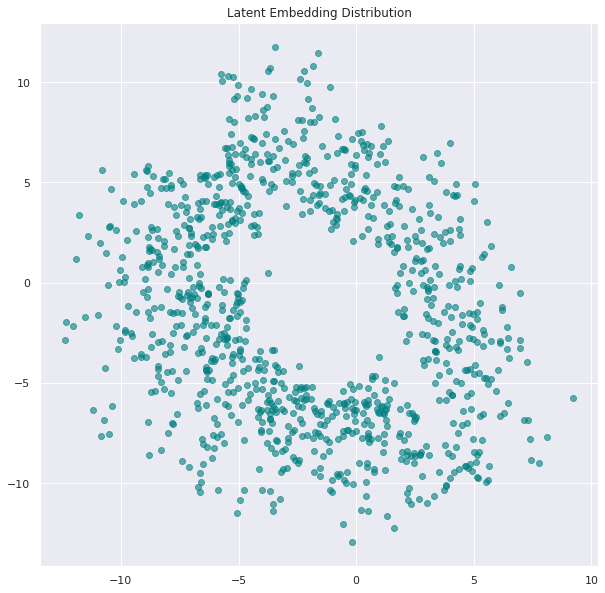

In [ ]:
plt.figure(figsize=(10, 10))

plt.scatter(z[:, 0], z[:, 1], c='teal', alpha=0.6)
plt.title('Latent Embedding Distribution')
plt.show()

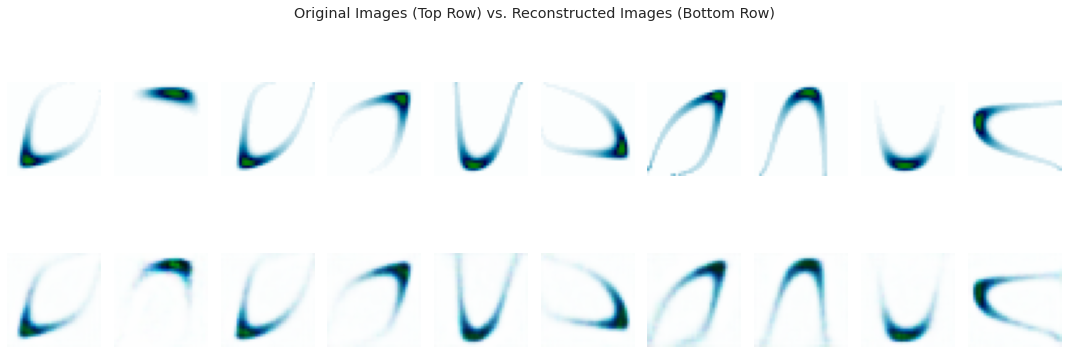

In [ ]:
index = np.random.choice(N, 10)
plt.figure(figsize = (15, 6))

for i in range(10):
  image = images[index[i]]
  plt.subplot(2, 10, i+1)
  plt.imshow(image)
  plt.axis('off')

  image_recon = vae(image[None] / 255).mean()
  plt.subplot(2, 10, i+11)
  plt.imshow(image_recon[0])
  plt.axis('off')

plt.suptitle('Original Images (Top Row) vs. Reconstructed Images (Bottom Row)')
plt.tight_layout()
plt.show()

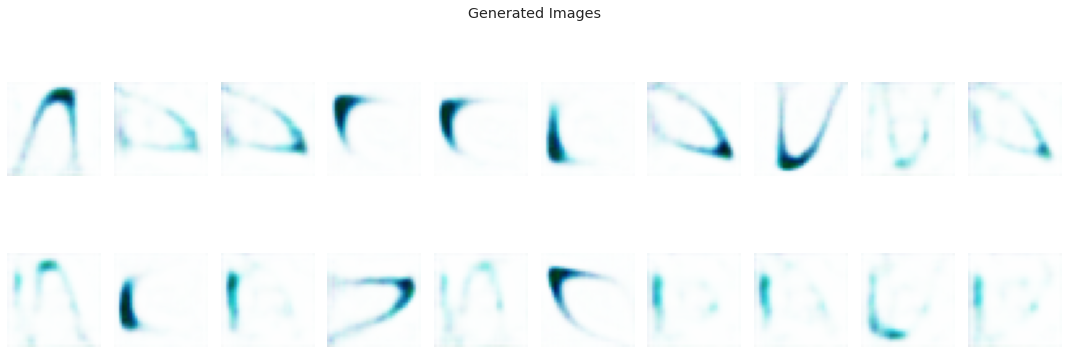

In [ ]:
latent_samples = prior.sample(6)
generated_image = decoder(latent_samples).mean()

plt.figure(figsize=(15, 6))
for i in range(20):
  plt.subplot(2, 10, i+1)
  plt.imshow(generated_image[i])
  plt.axis('off')

plt.suptitle('Generated Images')
plt.tight_layout()
plt.show()

## Creating Animation Visualizing Latent Space Interpolation

In [ ]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

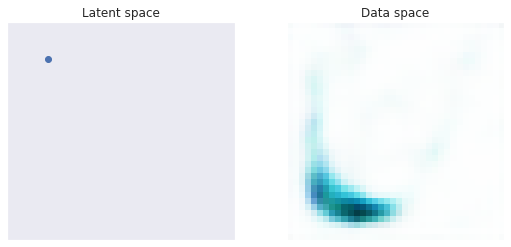

In [ ]:
# Create the animation

a = get_animation(latent_dim, decoder, interpolation_length=200)
HTML(a.to_html5_video())